<a href="https://colab.research.google.com/github/Dots11/DavesProjects/blob/master/07_milestone_project_1_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Downgrade Tensorflow Version (run this in Google Colab)
!pip install tensorflow==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
tf.__version__

'2.4.1'

# Milestone Project 1: Food Vision Big
See the annotated version of this notebook on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

## Check your GPU

* Google Colab offers free GPUs (thank you Google), however, not all of them are compatible with mixed precision training.

Google Colab offers:

* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus). 
**Resource**: You can read more about the benefits of mixed precision training in the TensorFlow Mixed Precision documentation: https://www.tensorflow.org/guide/mixed_precision

In [ ]:
!nvidia-smi

Thu Sep 15 19:04:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-00150034-4a2a-4046-f276-e43b80410996)


## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script we've got available can be found on GitHub: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
# Download helper function script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-15 19:04:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-15 19:04:23 (98.6 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [ ]:
# Import series of helper function for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlwo Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

Tensorflow datasets allows you to download data already in tensor format straight into your notebook 

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# List all avaiable datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


In [ ]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name = "food101",
                                             split= ["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised = True, # data gets returned in tuple format (data, label) 
                                             with_info = True) # what this does it downloads the tensor data, but also the meta data (ds_info)

## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [ ]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get the class names (we have to dig into the metadata "ds_info")
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [ ]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
# Output info about our training sample (through a dictionary)
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 288, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 93
  Class name (str form): steak
  


In [ ]:
#Looks like our labels are not one hot encoded - we may need to use loss sparse categorical cross entropy


In [ ]:
# What does our image tensor from TFDS's food101 look like?
image

<tf.Tensor: shape=(512, 288, 3), dtype=uint8, numpy=
array([[[148, 103,  36],
        [147, 102,  35],
        [147, 102,  35],
        ...,
        [146, 111,  53],
        [146, 111,  53],
        [146, 111,  53]],

       [[147, 102,  35],
        [147, 102,  35],
        [148, 103,  36],
        ...,
        [145, 110,  52],
        [145, 110,  52],
        [145, 110,  52]],

       [[143,  98,  31],
        [144,  99,  32],
        [146, 101,  33],
        ...,
        [146, 111,  55],
        [146, 111,  55],
        [145, 110,  54]],

       ...,

       [[113,  69,  94],
        [113,  69,  94],
        [112,  68,  93],
        ...,
        [ 77,  53,  67],
        [ 76,  52,  66],
        [ 78,  54,  68]],

       [[115,  71,  96],
        [115,  71,  96],
        [114,  70,  95],
        ...,
        [ 79,  55,  69],
        [ 81,  54,  69],
        [ 82,  55,  70]],

       [[116,  72,  97],
        [117,  73,  98],
        [117,  73,  98],
        ...,
        [ 75,  51,  6

In [ ]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from Tensorflow Datasets

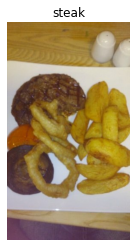

In [ ]:
# Plot an image tensor

import matplotlib.pyplot as plt
import numpy as np
# Plot an image tensor

plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False);

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized etc.)

Howevevr, not all data (including data from Tensorflow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know what models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 and 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions need to:

1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `unit8` to `float32`

In [ ]:
# (image, label)

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224): # usually a multiple of '8' e.g. '224' works best
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes 
  image to [img_shape, img_shape, colour_shape]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  #image = image/255. # scale image values (not required with EfficientNetBX models from tf.keras.applications)
  return tf.cast (image, tf.float32), label # return (float32_image, label) tuple



In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}")
print(f"Image after preprocessing:\n {image[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")


Image before preprocessing:
 [[[148 103  36]
  [147 102  35]
  [147 102  35]
  ...
  [146 111  53]
  [146 111  53]
  [146 111  53]]

 [[147 102  35]
  [147 102  35]
  [148 103  36]
  ...
  [145 110  52]
  [145 110  52]
  [145 110  52]]]..., 
Shape: (512, 288, 3), 
Datatype: <dtype: 'uint8'>
Image after preprocessing:
 [[[148 103  36]
  [147 102  35]
  [147 102  35]
  ...
  [146 111  53]
  [146 111  53]
  [146 111  53]]

 [[147 102  35]
  [147 102  35]
  [148 103  36]
  ...
  [145 110  52]
  [145 110  52]
  [145 110  52]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch & and prepare datasets

We're now goiong to make our data input pipeline run really fast.

For more resources on this, I'd highly recommend going through the following guide: https://www.tensorflow.org/guide/data_performance, at minimum, "best practice summary"

In [ ]:
# Map preprocessing function to training (and parallellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls = tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE).cache()

In [ ]:
tf.data

<module 'tensorflow._api.v2.data' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/data/__init__.py'>

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <CacheDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

> "Hey, TensorFlow, map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch"

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction



In [ ]:
# Create tensorboard callback (import from helperfunctions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = "val_acc",
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      verbose = 0) #  don't print whether or not model is being saved

## Setup mixed precision training
First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [ ]:
# Turn on mixed precision training
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

In [ ]:
# Setting the dtype policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# mixed_precision.set_global_policy('mixed_float16') #(equivalent to the two lines above)


In [ ]:
# Checking our global policy
mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [ ]:
# Building the model
inputs = keras.Input(shape=(784,), name='digits')
if tf.config.list_physical_devices('GPU'):
  print('The model will run with 4096 units on a GPU')
  num_units = 4096
else:
  # Use fewer units on CPU so the model finishes in a reasonable amount of time
  print('The model will run with 64 units on a CPU')
  num_units = 64
dense1 = layers.Dense(num_units, activation='relu', name = 'dense_1')
x = dense1(inputs)
dense2 = layers.Dense(num_units, activation='relu', name = 'dense_2')
x = dense2(x)

The model will run with 4096 units on a GPU


## Build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224,224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name = "input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescaling(1./255)(x) # get your values between 0 and 1

x = base_model(inputs, training = False) # makes sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x) # this time we need to separate the activation layer from the dense layer. So Dense layer will remain in 'float16' and outputs layer will be in 'float32'
outputs = layers.Activation("softmax", dtype = tf.float32, name="softmax_float32")(x) #will be in 'float32'
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
len(class_names)

101

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=93>

## Checking layer dtype policies (are we using mixed precision?)

In [ ]:
model.layers


In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see@
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not? (if `False`, the weights are frozen)
* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_policy`: the data type policy a layer computes on its variables with

In [ ]:
# Check the dtype_policy attributes of layers in the base model 
for layer in model.layers[1].layers[:20]: # Check the layers of the base model (layer at index 1 of `model')
  print(layer.name, layer.trainable, layer.dtype_policy)

input_1 False <Policy "float32">
rescaling False <Policy "mixed_float16">
normalization False <Policy "float32">
stem_conv_pad False <Policy "mixed_float16">
stem_conv False <Policy "mixed_float16">
stem_bn False <Policy "mixed_float16">
stem_activation False <Policy "mixed_float16">
block1a_dwconv False <Policy "mixed_float16">
block1a_bn False <Policy "mixed_float16">
block1a_activation False <Policy "mixed_float16">
block1a_se_squeeze False <Policy "mixed_float16">
block1a_se_reshape False <Policy "mixed_float16">
block1a_se_reduce False <Policy "mixed_float16">
block1a_se_expand False <Policy "mixed_float16">
block1a_se_excite False <Policy "mixed_float16">
block1a_project_conv False <Policy "mixed_float16">
block1a_project_bn False <Policy "mixed_float16">
block2a_expand_conv False <Policy "mixed_float16">
block2a_expand_bn False <Policy "mixed_float16">
block2a_expand_activation False <Policy "mixed_float16">


In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [ ]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs = 3,
                                                     steps_per_epoch = len(train_data),
                                                     validation_data = test_data,
                                                     validation_steps = (0.15 * len(test_data)),
                                                     callbacks = [create_tensorboard_callback(dir_name ="training_logs",
                                                                                              experiment_name = "efficientnetb0_101_classes_feature_extract"),
                                                                  model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_feature_extract/20220915-190428
Epoch 1/3
2368/2368 [==============================] - 116s 43ms/step - loss: 2.3368 - accuracy: 0.4628 - val_loss: 1.2223 - val_accuracy: 0.6796


Epoch 2/3
2368/2368 [==============================] - 98s 41ms/step - loss: 1.3134 - accuracy: 0.6625 - val_loss: 1.1222 - val_accuracy: 0.7038


Epoch 3/3
2368/2368 [==============================] - 101s 42ms/step - loss: 1.1397 - accuracy: 0.7041 - val_loss: 1.0875 - val_accuracy: 0.7093


In [ ]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 35s 44ms/step - loss: 1.0838 - accuracy: 0.7071


[1.0838165283203125, 0.7071287035942078]

##Off to you...
We've covered a lot of ground so far but since this is a milestone project, it's time for you to takeover.

More specifically, your challenge is to complete the TEMPLATE version of 07 to obtain a computer vision model (building off the one we've built in this notebook) to beat the DeepFood paper.

In other words, you're going to create Food Vision Big!!!

You can find the template notebook here: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/TEMPLATE_07_food_vision_milestone_project_1.ipynb

And if you get stuck, you can refer to the example version (non-template): https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb